In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
from astropy.io import fits

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175, Omega_b = 0.049, h = 0.6711, sigma8 = 0.834, n_s = 0.9649, 
                      matter_power_spectrum='linear')

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar = np.load('./default_config.npy', allow_pickle = True)[()]

#Just to make the variation in params more extreme
bpar['mu_beta'] = 1

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

## Download files

These are files from the [ULAGAM simulations](https://ulagam-simulations.readthedocs.io/) hosted on gdrive specifically for this example notebook

In [3]:
!rm shell.fits.fz halos.npy

!wget -O shell.fits.fz "https://drive.google.com/uc?export=download&id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6"
!wget -O halos.npy     "https://drive.google.com/uc?export=download&id=1JhtFwOzfHG5YWXUDYP1HFfAkq6v5YHKm"

--2025-11-07 15:05:36--  https://drive.google.com/uc?export=download&id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6
Resolving drive.google.com (drive.google.com)... 172.217.1.110, 2607:f8b0:4009:808::200e
Connecting to drive.google.com (drive.google.com)|172.217.1.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6&export=download [following]
--2025-11-07 15:05:36--  https://drive.usercontent.google.com/download?id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.32.1, 2607:f8b0:4009:81b::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.32.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5705280 (5.4M) [application/octet-stream]
Saving to: ‘shell.fits.fz’

shell.fits.fz       100%[===================>]   5.44M  3.95MB/s    in 1.4s    


# Load shell and catalog

In [4]:
min_z = 0.2129219
max_z = 0.2395602

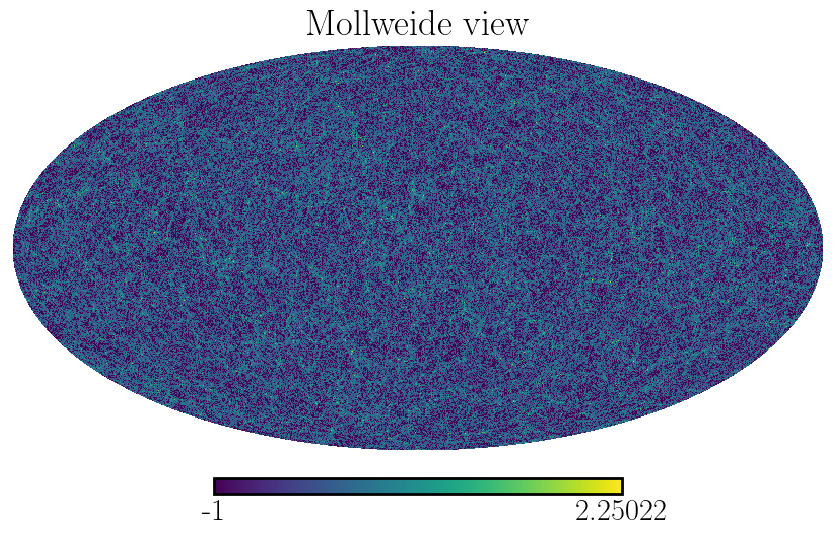

In [5]:
counts  = fits.open('shell.fits.fz')[1].data
density = counts/np.mean(counts) - 1

hp.mollview(np.log10(1.1 + density))

In [6]:
shell_thickness = ccl.comoving_radial_distance(cosmo, 1/(max_z + 1)) - ccl.comoving_radial_distance(cosmo, 1/(min_z + 1))
bpar['proj_cutoff'] = shell_thickness/2

print(f"SHELL IS {shell_thickness} MPC")

SHELL IS 103.99377732916025 MPC


In [7]:
#This is set in units of halo R200c radius.
#You want this to be larger than the radius where you displacement
#function asymptotes to 0
bpar['epsilon_max'] = 10

# Load models

In [8]:
#Load the standard profile models
DMO = bfg.Profiles.DarkMatterOnly(**bpar)
DMB = bfg.Profiles.DarkMatterBaryon(**bpar)

#Do the pixel level convolutions
PIX = bfg.HealPixel(1024)
DMO = bfg.ConvolvedProfile(DMO, PIX)
DMB = bfg.ConvolvedProfile(DMB, PIX)

#Regular displacement model. We init it and also run the tabulator
Displacement_noc200c = bfg.Profiles.Baryonification2D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
Displacement_noc200c.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                                        R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)


#Modified model. The "other_params" dictionary can contain any parameter that is used in the model.
#For example, it could be proj_cutoff (see Example 2) or M_c, etc.
Displacement = bfg.Profiles.Baryonification2D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
Displacement.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                                R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True,
                                other_params = {'cdelta' : np.linspace(1, 10, 10)})

Building Table:   0%|                                                                                                                 | 0/2 [00:00<?, ?it/s]/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Base.py:243: UserWarning: WARNING: Profile is zero/negative in some places.Likely a convolution artifact for objects smaller than the pixel scale
  warnings.warn("WARNING: Profile is zero/negative in some places."
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:773: UserWarning: Decrease integral lower limit, r_min_int (1e-08) < minimum radius (8.333333333333334e-10)
  warnings.warn(f"Decrease integral lower limit, r_min_int ({self.r_min_int}) < minimum radius ({np.min(r)})", UserWarning)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:775: UserWarning: Increase integral upper limit, r_max_int (100000.0) < maximum radius (1200000.0)
  warnings.

In [9]:
#Get the pressure profile
Gas = bfg.Profiles.Gas(**bpar)
DMB = bfg.Profiles.DarkMatterBaryon(**bpar, twohalo = bfg.Profiles.misc.Zeros())
PRS = bfg.Profiles.Pressure(gas = Gas, darkmatterbaryon = DMB)
PRS = bfg.Profiles.ThermalSZ(PRS) #Converts Pressure from cgs to compton-y (dimensionless) units

#Now add the HealPix pixel (a redshift-dependent kernel)
Pix = bfg.utils.HealPixel(NSIDE = 1024)
PRS = bfg.utils.ConvolvedProfile(PRS, Pix)

#Now tabulate it (this does both 3D and 2D tabulation)
PRS_noc200c = bfg.utils.TabulatedProfile(PRS, cosmo)
PRS_noc200c.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                               R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)

#Same as before, tabulate with an external param. So this extends the dimension of the
#table being pre-generated.
PRS = bfg.utils.ParamTabulatedProfile(PRS, cosmo)
PRS.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                       R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True,
                       other_params = {'cdelta' : np.linspace(1, 10, 10)})

Building Table: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/utils/Tabulate.py:263: RuntimeWarning: divide by zero encountered in log
  self.interp3D = interpolate.RegularGridInterpolator(input_grid_1, np.log(interp3D), bounds_error = False)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/utils/Tabulate.py:264: RuntimeWarning: invalid value encountered in log
  self.interp2D = interpolate.RegularGridInterpolator(input_grid_1, np.log(interp2D), bounds_error = False)
Building Table: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/utils/Tabulate.py:582: RuntimeWarning: divide by zero encountered in log
  self.interp3D = int

# Make Mock c200c catalog

In [10]:
#Load the halos from ULAGAM
halos   = np.load('halos.npy')
cdict   = {'Omega_m' : 0.3175, 'sigma8' : 0.834, 'h' : 0.6711, 'n_s' : 0.9649, 'w0' : -1, 'Omega_b' : 0.049}

#Generate a "noisy" concentration. Assumes the default Diemer relation
#plus a scatter of sigma ln(c200c) = 0.24 following Anbajagane++ 2022, arxiv:2109.02713
np.random.seed(42)
c200c_t = ccl.halos.ConcentrationDiemer15()(cosmo, halos['M'], a = 1/(1 + (min_z + max_z)/2))
c200c_o = c200c_t * np.clip((1 + np.random.rand(len(c200c_t)) * 0.24), 1, None)

#Put the objects in a halo catalog. When making "halos" you should  pass an array that
#contains the quantity you add to your extra tabulation. We are being precise to use "cdelta" as the name
#in both, as this is the name of the param used in the actual profiles/modelling.
halos   = bfg.utils.HaloLightConeCatalog(halos['ra'], halos['dec'], halos['M'], halos['z'], cdelta = c200c_o, cosmo = cdict)
shell   = bfg.utils.LightconeShell(map = counts, cosmo = cdict)

# Run Baryonification

In [11]:
Shell_fid = bfg.Runners.BaryonifyShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = Displacement, verbose = True)
Shell_noc = bfg.Runners.BaryonifyShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = Displacement_noc200c, verbose = True)

In [12]:
baryonified_shell_fid = Shell_fid.process()
baryonified_shell_noc = Shell_noc.process()

Baryonifying matter: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 18512/18512 [00:16<00:00, 1089.18it/s]


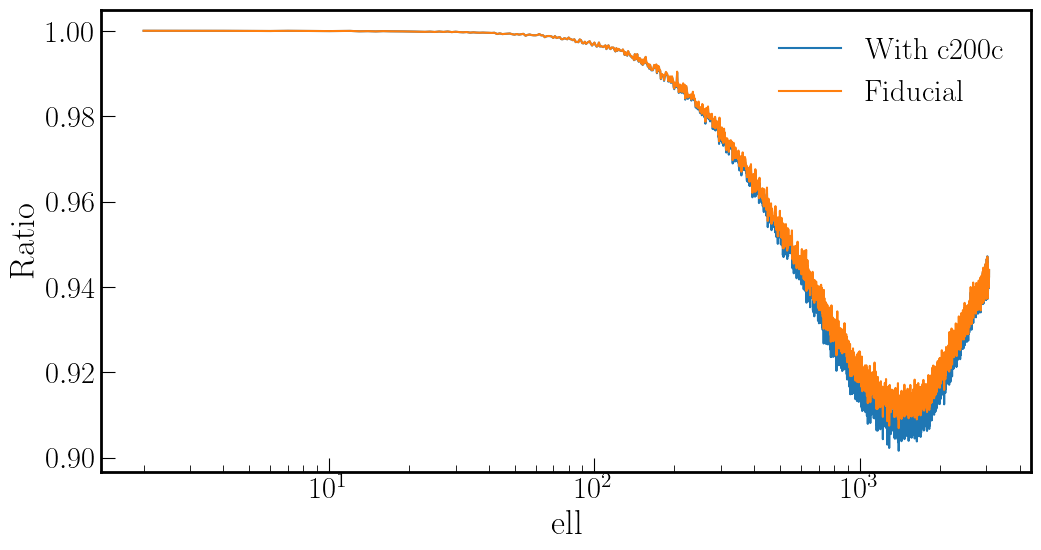

In [13]:
plt.figure(figsize = (12,6))
#Compute Cls of the original map
baseline = hp.anafast(counts)
ell      = np.arange(baseline.size)

for s, M in zip([baryonified_shell_fid, baryonified_shell_noc], ['With c200c', 'Fiducial']):
    
    #Compute Cls of the modified map
    modified = hp.anafast(s)
    
    #Plot ratios. Dont show monopole and dipole modes
    plt.plot(ell[2:], (modified/baseline)[2:], label = f'{M}')
    

plt.legend(frameon = False)
plt.xlabel('ell', size = 25)
plt.ylabel('Ratio', size = 25)
plt.xscale('log')

# Run painting

In [14]:
Shell_fid = bfg.Runners.PaintProfilesShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = PRS, verbose = True)
Shell_noc = bfg.Runners.PaintProfilesShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = PRS_noc200c, verbose = True)

In [15]:
tSZ_shell_fid = Shell_fid.process()
tSZ_shell_noc = Shell_noc.process()

Painting Profile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 18512/18512 [00:08<00:00, 2107.63it/s]


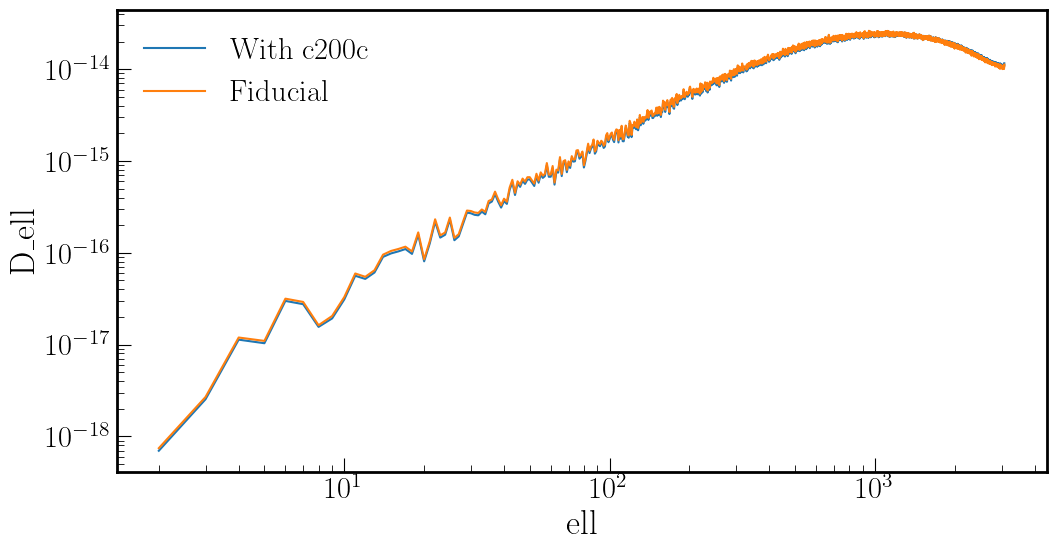

In [16]:
plt.figure(figsize = (12,6))

ell = np.arange(baseline.size)

for s, M in zip([tSZ_shell_fid, tSZ_shell_noc], ['With c200c', 'Fiducial']):
    
    #Compute Cls of the modified map
    modified = hp.anafast(s)
    
    #Plot ratios. Dont show monopole and dipole modes
    plt.plot(ell[2:], (ell * (ell + 1) / (2*np.pi) * modified)[2:], label = f'{M}')
    

plt.legend(frameon = False)
plt.xlabel('ell', size = 25)
plt.ylabel('D_ell', size = 25)
plt.xscale('log'); plt.yscale('log')

The impact of concentration's scatter is pretty low. Schneider 2019 found scatter in model params (not c200c) was subdominant so this result on c200c is also somewhat expected. We've done a pretty simple test here, but in Anbajagane++ we find using TNG concentrations lead to similar conclusions of the scatter having minimal impact.

However, the model could be tuned to have a strong c200c dependence. See the zeta params in BaryonForge.